## Data analysis code for gain=1000 and gain=5000 data taken on 02/25/2025 and 02/27/2025. Plots histogram and fits with a Gaussian.

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py

## Define functions for Gaussian fitting

In [2]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [3]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            print("5 sigma threshold is", pf[2]+pf[1]*5, "with uncertainty", pferr[2]+pferr[1]*5)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

# Plot gain=5000 data
10mW, gain=5000.

In [4]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\03\07'
seq_binning1 = [26,27] #binning=1x1
labels = ['10mW, 1", 4x4','DARK, 1", 4x4', ]

171
170


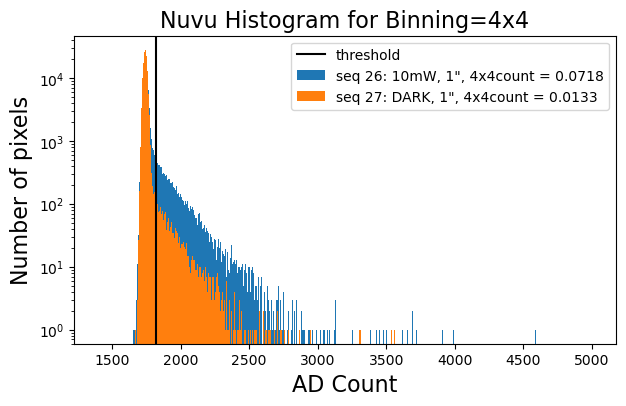

In [5]:
counting_threshold = 1820 #Arbitrarily chosen for now

all_images_binning1 = np.full((len(seq_binning1), 30, 512//4, 512//4), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==30:
            break
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 5000, 2)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(np.argmax(hist))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1., label = 'seq %i: '%seq_binning1[i]+ labels[i] +'count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Nuvu Histogram for Binning=4x4', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

In [6]:
0.0718/0.0133

5.398496240601505

In [7]:
100 * 200 * 0.01 / (128*128)

0.01220703125

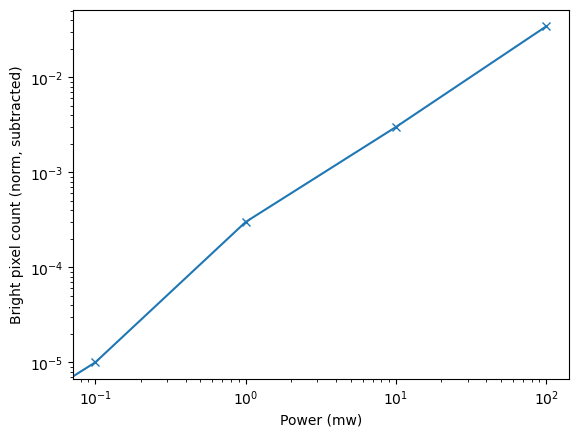

In [9]:
powers = np.array([0,0.1,1,10,100])
counts = np.array([0.0004, 0.00041, 0.0007, 0.0034, 0.0348])

plt.plot(powers, counts-counts[0], marker = 'x')
plt.xlabel('Power (mw)')
plt.ylabel('Bright pixel count (norm, subtracted)')

plt.xscale('log')
plt.yscale('log')

In [10]:
# plt.figure(num = 'difference')
# plt.imshow(np.mean(all_images_binning1[0,:,:,:], axis=0) - np.mean(all_images_binning1[1,:,:,:], axis=0))
# plt.colorbar()
# plt.title('No acktar - Acktar')

# Define PC thresholds for binning=1x1 and 4x4
Code copied from 03/04/2025
## Let's do 1x1...

Text(0, 0.5, 'Number of Pixels')

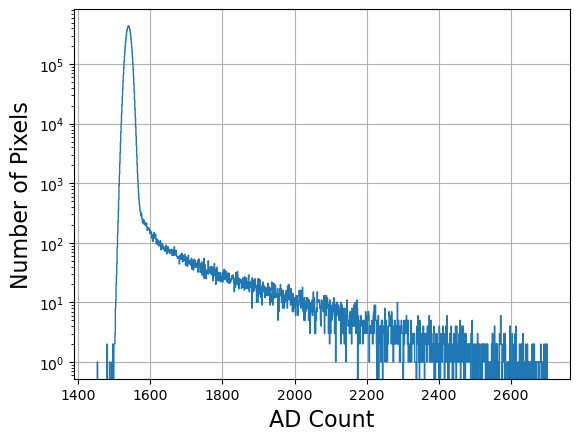

In [22]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\0008'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[9.81025509e-02 7.00000000e+00 1.54000000e+03]
[69, 109, 1513, 1567, 1480, 1900]
fit region: AD count =  1520 to  1559
Fit Converged
Converged with chi-squared 991.5733889103292
Number of degrees of freedom, dof = 37
Reduced chi-squared 26.79928078136025
Inital guess values:
  p0 = [0.09810255085364009, 7, 1540]
Best fit values:
  pf = [0.0995410141664769, 7.161619276283065, 1539.8804005814172]
Uncertainties in the best fit values:
  pferr = [3.569442408288122e-05, 0.0020422448756222283, 0.002626859029737504]
5 sigma threshold is 1575.6884969628325 with uncertainty 0.012838083407848646


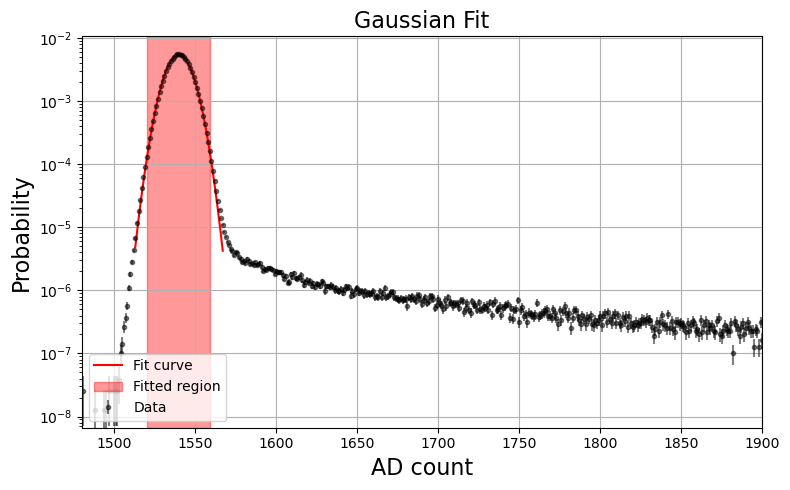

In [21]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1520
End_gaussian=1560

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

## Now let's do 4x4...

Text(0, 0.5, 'Number of Pixels')

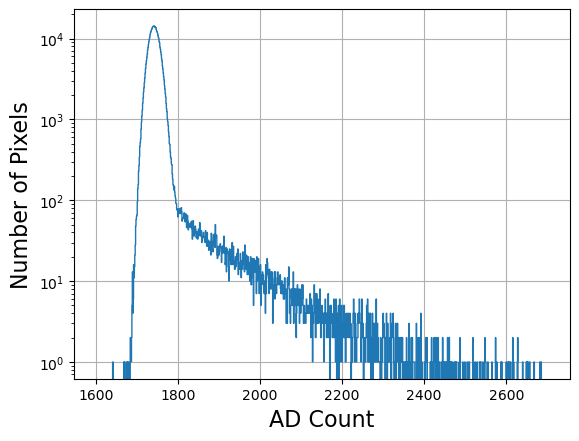

In [24]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 128, 128), np.NaN)
folder_path = folder_path_day + '\\0027'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1600.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[5.11270164e-02 7.00000000e+00 1.74200000e+03]
[106, 179, 1700, 1787, 1480, 1900]
fit region: AD count =  1707 to  1779
Fit Converged
Converged with chi-squared 803.2145790305275
Number of degrees of freedom, dof = 70
Reduced chi-squared 11.474493986150392
Inital guess values:
  p0 = [0.05112701640723801, 7, 1742]
Best fit values:
  pf = [0.09783310339975801, 13.576675635920834, 1742.0453896312852]
Uncertainties in the best fit values:
  pferr = [0.00014176647321608972, 0.016105591263367414, 0.020264767965198334]
5 sigma threshold is 1809.9287678108894 with uncertainty 0.1007927242820354


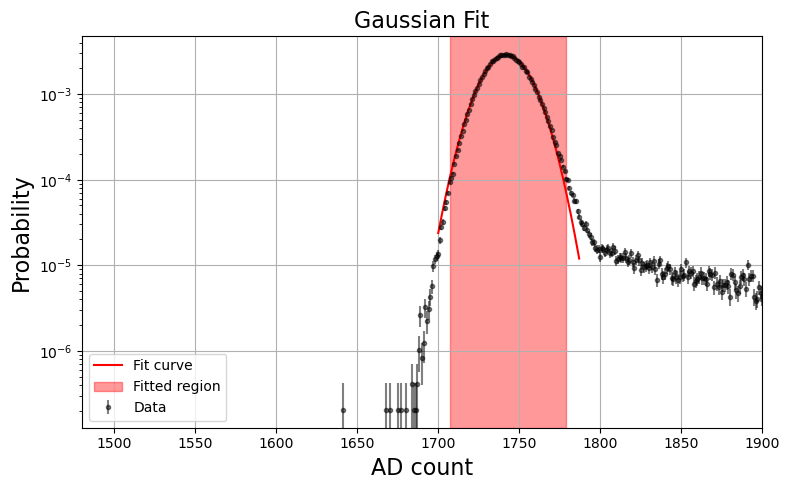

In [29]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1707
End_gaussian=1780

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Binning 1x1

In [31]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\03\07'
seq_binning1 = [2,22,31,8] #binning=1x1
labels = ['Before Acktar #2, 1" iris, ', 'After Acktar #2, 1" iris, ', 'After Acktar #3, 1" iris, ', 'DARK, ',]

1541
1538
1532
1532


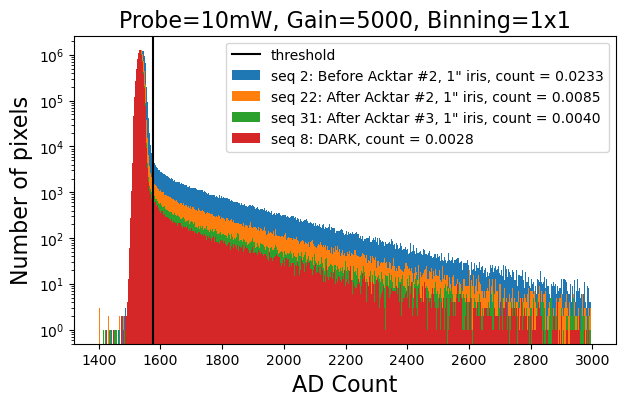

In [40]:
counting_threshold = 1576 

all_images_binning1 = np.full((len(seq_binning1), 30, 512, 512), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==30:
            break
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            if seq==8:
                image_data=image_data-np.ones(np.shape(image_data))*6 #added
            all_images_binning1[count_a, count_b, :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 3000, 3)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(bin_edges[np.argmax(hist)])
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1.0, label = 'seq %i: '%seq_binning1[i]+ labels[i] +'count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Probe=10mW, Gain=5000, Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

# Binning 4x4

In [10]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\03\07'
seq_binning1 = [26,32,27] #binning=1x1
labels = ['After Acktar #2, 1" iris, ', 'After Acktar #3, 1" iris, ', 'DARK, ',]
colors=['#ff7f0e','#2ca02c','#d62728']

1742
1730
1740


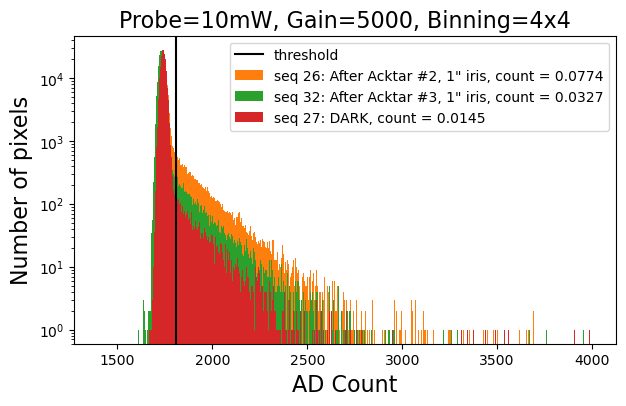

In [12]:
counting_threshold = 1810

all_images_binning1 = np.full((len(seq_binning1), 30, 512//4, 512//4), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==30:
            break
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            # if seq==27:
            #     image_data=image_data-np.ones(np.shape(image_data))*10 #added
            all_images_binning1[count_a, count_b, :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 4000, 2)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(bin_edges[np.argmax(hist)])
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1., color=colors[i], label = 'seq %i: '%seq_binning1[i]+ labels[i] +'count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Probe=10mW, Gain=5000, Binning=4x4', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

# Compare 1" and 2" iris  - Binning 1x1

In [48]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\03\07'
seq_binning1 = [34,31,8] #binning=1x1
labels = ['After Acktar #3, 2" iris, ', 'After Acktar #3, 1" iris, ', 'DARK, ',]

1532
1534
1540


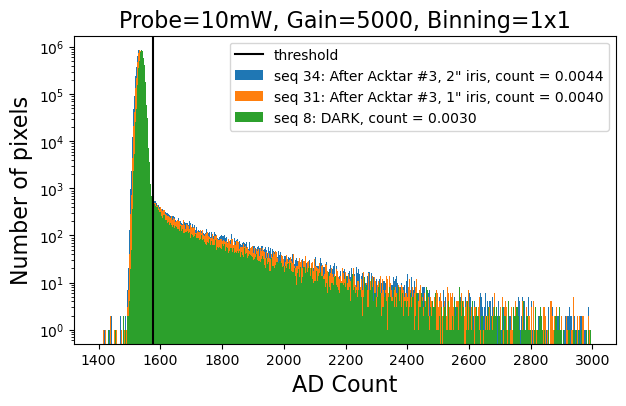

In [49]:
counting_threshold = 1576

all_images_binning1 = np.full((len(seq_binning1), 30, 512, 512), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==30:
            break
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 3000, 2)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(bin_edges[np.argmax(hist)])
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1., label = 'seq %i: '%seq_binning1[i]+ labels[i] +'count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Probe=10mW, Gain=5000, Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

# Compare 1" and 2" iris  - Binning 4x4

In [50]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\03\07'
seq_binning1 = [33,32,27] #binning=1x1
labels = ['After Acktar #3, 2" iris, ', 'After Acktar #3, 1" iris, ', 'DARK, ',]

1730
1730
1740


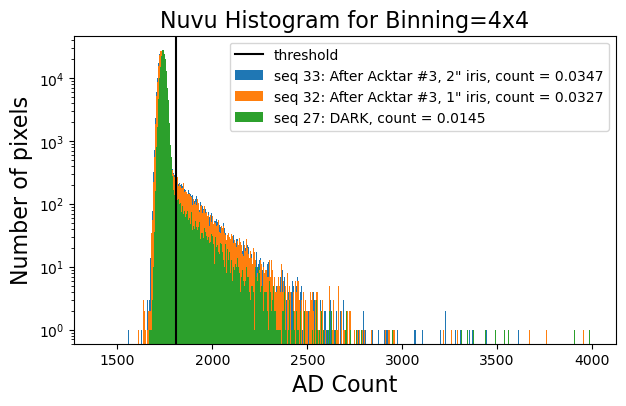

In [51]:
counting_threshold = 1810 #Arbitrarily chosen for now

all_images_binning1 = np.full((len(seq_binning1), 30, 512//4, 512//4), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==30:
            break
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 4000, 2)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(bin_edges[np.argmax(hist)])
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1., label = 'seq %i: '%seq_binning1[i]+ labels[i] +'count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Nuvu Histogram for Binning=4x4', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()